# 1. Data Analysis

***

In [1]:
# ##################################################################################################################################################################
#                      !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ##################################################################################################################################################################
#
# At the moment, only a part of the hybrid metal(III) halides dataset is presented, it will be fully available after the article is rejected.
#
# Your results from this notebook will be different and not very informative.
#
# Therefore, where important information is displayed, copies of the outputs obtained on all data are given.
#
# ##################################################################################################################################################################
#                      !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ##################################################################################################################################################################

In this notebook:
 1. Description of sources data
 2. Preliminary data analysis
 3. Finding Outliers
 4. Prepare data for training

**Can be done by clicking "Run all"**

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

***

## Data collection and dataset compilation
The compilation of the dataset, *which took more than a month of work*, is not presented here (because the volume of this work cannot be beautifully designed and shown in a perceived form).

The workflow was as follows:
1. Request to the database of crystal structure (CSD, ConQuest API);
2. Manual selection of the necessary objects;
3. Uploading data in the form of [CIF](https://en.wikipedia.org/wiki/Crystallographic_Information_File)-files, a table with general information and a small amount of SMILES for compounds;
4. Combining the results of different queries into one array;
5. Calculation of geometric parameters (lengths of angle bonds) by the program ToposPro 5.2.2, entering data into the dataset;
6. Search articles for each object, view them, extract the band gap value and information about band gap types;
7. An attempt at automated generation of descriptors for Hal…Hal contacts using a number of different crystallographic programs, such as Mercury, Diamond, ToposPro, and python API for CSD - was failed;
8. Manual viewing of crystal structures and mining Hal…Hal contacts information, classification by type of $\{MHal_{4}\}^{-}$;
9. Generation of features (a.k.a. descriptors) based on the received data (not present in the repository now, will appear later);
10. Checking all data.

This amounted to largest amount of work.

***

## Dataset

In [4]:
# Open dataset file 'MX4_Dataset_v1.csv'
df = pd.read_csv('MX4_Dataset_v1.csv', sep='\t', index_col=[0])
df.head(10)

,REFCODE,Chemical formula,Type MHal4,BG Type,Band gap,M(III),Hal,M,X,Bi,...,ADAT,MDAT,NBSI,CDRE,MSDB,NBIT,MATF,CATF,ccdc QUAL,ccdc PROPS
0,AGODEI,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20181008.0,20200114.0,0.0,0.0,0,112.0,2.0,3.0,"""TEMP: 150 K","""COLOR: red ""HABIT: block"
1,AGODIM,NaN,a,d,2.07,Bi,I,0.0,0.0,1.0,...,20181008.0,20181017.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 150 K","""COLOR: red ""HABIT: block"
2,AGODOS,NaN,a,d,1.97,Bi,I,0.0,0.0,1.0,...,20181008.0,20200114.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 120 K","""COLOR: red ""HABIT: block"
3,AGODOS01,NaN,a,d,1.94,Bi,I,0.0,0.0,1.0,...,20191202.0,20200114.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 297 K","""COLOR: red ""HABIT: block"
4,AQALEM,NaN,a,NaN,NaN,Sb,Cl,1.0,2.0,0.0,...,20210323.0,20210408.0,0.0,0.0,0,91.0,3.0,3.0,"""TEMP: 298 K","""COLOR: colorless ""HABIT: block"
5,AYENEZ,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,103.0,3.0,3.0,"""TEMP: 292 K","""COLOR: red ""HABIT: Prism"
6,AYENEZ01,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,103.0,3.0,3.0,"""TEMP: 150.0 K","""COLOR: red ""HABIT: Prism"
7,AYENOJ,NaN,a,d,1.95,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,109.0,2.0,3.0,"""TEMP: 292.2 K","""COLOR: red ""HABIT: Prism"
8,AYENOJ01,NaN,a,d,1.95,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,109.0,2.0,3.0,"""TEMP: 149.9 K","""COLOR: red ""HABIT: Prism"
9,AYEPAX,NaN,a,d,1.92,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,108.0,3.0,3.0,"""TEMP: 286 K","""COLOR: red ""HABIT: Prism"


In each row there is one object corresponding one crystal structure of hybrid metal(III) halide with $\{MHal_{4}\}^{-}$ anion ($M - metal: Bi^{3+}, Sb^{3+}; Hal - halogen: I^{-}, Br^{-}, Cl^{-}$).

Below is a description of the information contained in the columns. All descriptors are self-generated. Unless otherwise noted, structure information is derived from CSD ([Cambridge Structural Database](https://www.ccdc.cam.ac.uk/solutions/software/csd/)):
* **REFCODE** - CSD - identifier;
* **Chemical formula** - chemical formula of compound. The information generated from structural data;
* **Type MHal4** - isomer of $\{MHal_{4}\}^{-}$ anion: **a** - *$\alpha$-type*, **b** - *$\beta$-type*, **y** - *$\gamma$-type* (**See bellow I**), **no st data** - *no structural data*, there are no atomic coordinates in the CIF-file, it is impossible to calculate descriptors and analyze the crystal structure. The information generated from structural data;
* **BG Type** - band gap type: **d** - *direct*, **i** - *indirect*, **cht** - *charge transfer*. In most cases, this corresponds to the optical data processing model (Kubelka-Munk or Tauc models), but if the formation of an anion-to-cation charge transfer band gap is reliably confirmed, '**cht**' is presented. The information obtained from articles;
* **Band gap** - band gap value, eV. The information obtained from articles;
* **M(III)** - metal in anion: bismuth (**Bi**) or antimony (**Sb**), all incoming elements are listed for mixed compositions. The information obtained from CIF-file;
* **Hal** - halogen in anion: iodine (**I**), bromine (**Br**) or chlorine (**Cl**), all incoming elements are listed for mixed compositions. The information obtained from CIF-file;
* **M** - modify Label-encoding of metal: 0 for Bi, 1 for Sb, intermediate fractional value for mixed compositions (chemical composition descriptor);
* **X** - modify Label-encoding of halogen: 0 for I, 1 for Br, 2 for Cl, intermediate fractional value for mixed compositions (chemical composition descriptor);
* **Bi** - modify One-hot-encoding of metal: fraction of Bi from the metal in the anion (chemical composition descriptor);
* **Sb** - modify One-hot-encoding of metal: fraction of Sb from the metal in the anion (chemical composition descriptor);
* **I** - modify One-hot-encoding of halogen: fraction of I from the halogen in the anion (chemical composition descriptor);
* **Br** - modify One-hot-encoding of halogen: fraction of Br from the halogen in the anion (chemical composition descriptor);
* **Cl** - modify One-hot-encoding of halogen: fraction of Cl from the halogen in the anion (chemical composition descriptor);
* **Temperature** - temperature of the X-ray diffraction experiment, K;
* **min Hal...Hal** - minimal distance between neighboring anions, Å (NCI descriptor);
* **aver Hal...Hal** - average distance between neighboring anions that less sum of Van der Waals radius of halogens or minimal distance between neighboring anions if there are no NCI, Å (NCI descriptor);
* **Number of Hal...Hal contacts** - number of Hal...Hal contacts with distances less sum of Van der Waals radius (NCI descriptor);
* **N/aver-d** - ratio of **Number of Hal...Hal contacts** to **aver Hal...Hal**, (NCI descriptor);
* **Hal-t1**, **Hal-t2**, **Hal-d1**, **Hal-d2**, **Hal-d3**, **Hal-d4** - distances M-Hal in anion (**See bellow II**), Å (anion geometrical descriptors);
* **t1-t2**, **t1-d1**, **t1-d2**, **t1-d3**, **t1-d4**, **t2-d1**, **t2-d2**, **t2-d3**, **t2-d4**, **d1-d2**, **d1-d3**, **d1-d4**, **d2-d3**, **d2-d4**, **d3-d4** - angles Hal-M-Hal in anion (**See bellow II**), ° (anion geometrical descriptors);
* **delta d** - ${\Delta}d$, a measure of the distortion degree of octahedron $MHal_{6}$ in anion based on the deviation of distances from the mean: ${\Delta}d=\frac{1}{6}\displaystyle\sum_{i=1}^{6}\left(\frac{r_{i}-\bar{r}}{\bar{r}}\right)^{2}$, where $r$ - M-Hal distance (anion geometrical descriptor);
* **sigma^2** - $\sigma^{2}$, a measure of the distortion degree of octahedron $MHal_{6}$ in anion based on the deviation of 12 angles from 90°: $\sigma^{2}=\frac{1}{11}\displaystyle\sum_{i=1}^{12}\left(\alpha_{i}-90\right)^{2}$, where $\alpha$ - angle Hal-M-Hal (anion geometrical descriptor);
* **cation smiles** - SMILES presentation of cation. The information generated from structural data from CIF-file;
* **cation substructure smiles** - SMILES presentation of cation substructure: cation & solvated molecules. The information generated from structural data from CIF-file;
* **Topos data** - information about distances M-Hal and angles Hal-M-Hal (dia-file) self-generated by ToposPro 5.2.2. from CIF-files;
* **Hal...Hal contacts data** - all with distances less sum of Van der Waals radius;
* **DOI**, **Authors**, **Journal**, **Journal volume**, **Journal page**, **Journal year** - information about publication in which the crystal structure is reported;
* **Initial chemical formula** - chemical formula from CSD;
* **Symmetry space group name**, **Symmetry Int Tables number**, **cell length a**, **cell length b**, **cell length c**, **cell angle alpha**, **cell angle beta**, **cell angle gamma**, **cell volume**, **rcell length a**, **rcell length b**, **rcell length c**, **rcell angle alpha**, **rcell angle beta**, **rcell angle gamma**, **rcell volume**, **molecular volume**, **cell RESIDUES**, **cell formula units Z**, **cell formula units Zprime**, **Crystal preparation**, **Crystal description**, **Polymorphism**, **Crystal notes**, **refine ls R factor**, **exptl crystal density CCDC**, **exptl crystal density diffrn**, **diffrn measurement device**, **Disodering**, **Experimental quality**, **ccdc REMARK**, **PREF**, **BATC**, **ADAT**, **MDAT**, **NBSI**, **CDRE**, **MSDB**, **NBIT**, **MATF**, **CATF**, **ccdc QUAL**, **ccdc PROPS** - crystallographic information, information about the X-ray diffraction experiment and additional information from СSD;
The information in the remaining columns corresponds to their titles.

Thus, we use 3 groups of descriptors to describe chemical honeycomb, anion geometry and non-covalent interactions between them.

*NCI - Non-Covalent Interaction*


In [5]:
# Information about data in columns (None null values, data type)
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 102 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    REFCODE                       187 non-null    object 
 1    Chemical formula              0 non-null      float64
 2    Type MHal4                    187 non-null    object 
 3    BG Type                       98 non-null     object 
 4    Band gap                      105 non-null    float64
 5    M(III)                        187 non-null    object 
 6    Hal                           187 non-null    object 
 7    M                             187 non-null    float64
 8    X                             187 non-null    float64
 9    Bi                            187 non-null    float64
 10   Sb                            187 non-null    float64
 11   I                             187 non-null    float64
 12   Br                            187 non-null    fl

<ipython-input-5-6f489487961e>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


In [6]:
print(f'''Dataset contains {df.shape[0]} object (crystal structures) that correspond to {len(set([x[:6] for x in df['REFCODE']]))-1} different compounds (structures of some compounds are determined at different temperatures).

Band gap values experimental determine for {sum(df["Band gap"].notna())} objects.

For {sum(df["Type MHal4"]=="no st data")} structures there are no atomic coordinates in the CIF-file, it is impossible to calculate descriptors. For {df[(df["Type MHal4"]=="no st data")&(df["Band gap"].notna())].shape[0]} of them Band gap value is known.

For {df[(df["Type MHal4"]=="a")&(df["Hal-t1"].isna())].shape[0]} objects a several symmetrical independent metal atoms are observed in the crystal structure. {df[(df["Band gap"].notna())&(df["Hal-t1"].isna())&(df["Type MHal4"]=="a")].shape[0]} of them have band gap values so only geometric descriptors Deltad_d and sigma^2 can be used to predict the gap for them.

There are {sum(df["Type MHal4"]=="y")} structures with y-type anion. Our models will not be able to describe them.

Thus for band gap prediction {df[(df["Type MHal4"]=="a")&(df["Band gap"].notna())].shape[0]}/{df[(df["Type MHal4"]=="a")&(df["Band gap"].notna())&(df["Hal-t1"].notna())].shape[0]} potential objects remain.

For establishing relationships between "cation-structure parameters" {sum(df["Type MHal4"]=="a")} objects can be used.''')

Dataset contains 187 object (crystal structures) that correspond to 130 different compounds (structures of some compounds are determined at different temperatures).

Band gap values experimental determine for 105 objects.

For 25 structures there are no atomic coordinates in the CIF-file, it is impossible to calculate descriptors. For 8 of them Band gap value is known.

For 8 objects a several symmetrical independent metal atoms are observed in the crystal structure. 3 of them have band gap values so only geometric descriptors Deltad_d and sigma^2 can be used to predict the gap for them.

There are 3 structures with y-type anion. Our models will not be able to describe them.

Thus for band gap prediction 94/91 potential objects remain.

For establishing relationships between "cation-structure parameters" 159 objects can be used.


In [7]:
# ##############################################  On full dataset will be ##############################################
#
# Dataset contains 187 object (crystal structures) that correspond to 130 different compounds (structures of some compounds are determined at different temperatures).
#
# Band gap values experimental determine for 105 objects.
#
# For 25 structures there are no atomic coordinates in the CIF-file, it is impossible to calculate descriptors. For 8 of them Band gap value is known.
#
# For 8 objects a several symmetrical independent metal atoms are observed in the crystal structure. 3 of them have band gap values so only geometric descriptors Deltad_d and sigma^2 can be used to predict the gap for them.
#
# There are 3 structures with y-type anion. Our models will not be able to describe them.
#
# Thus for band gap prediction 94/91 potential objects remain.
#
# For establishing relationships between "cation-structure parameters" 159 objects can be used.

### I. Isomerism of $\{MHal_{4}\}^{-}$ anion

There are three types of anions $\{MHal_{4}\}^{-}$. They all consist of octahedrons, which are bonded with each other by a common edge. A different order of connection of octahedra leads to a different spatial arrangement of atoms.

The first of them $\alpha-\{MHal_{4}\}^{-}$- occurs most often, we consider it in this problem. It's a zigzag chain:

<div>
<img src="images/a.png" width="1000"/>
</div>

The second and third ($\beta$ and $\gamma$) are rather rare, known only from 1 compound. For the second, the chain $\beta-\{MHal_{4}\}^{-}$ is also a zigzag, but more curved:

<div>
<img src="images/b.png" width="1000"/>
</div>

And in the third, a helix and contacts inside the anion are formed (shown by a dashed line in purple):

<div>
<img src="images/y.png" width="1000"/>
</div>

### II. Anion geometry description

Designation scheme of atoms in anione $\alpha$-$\{MHal_{4}\}^{-}$:


<div>
<img src="images/MX4_anion.png" width="800"/>
</div>

Metal atoms are named $M$.
Terminate atoms of halogen are designated as $Hal-ti$ ($i$ = 1 or 2). They are bonded with only 1 atom $M$.
Bridged (doubly coordinated) atoms of halogens are designated as $Hal-di$. They are bonded with 2 atom $M$.

Descriptors **Hal-t1**, **Hal-t2**, **Hal-d1**, **Hal-d2**, **Hal-d3**, and **Hal-d4** correspond to the bond length $M—Hal$ with the same designated halogen atom.
Descriptors **t1-t2**, **t1-d1**, **t1-d2**, **t1-d3**, **t1-d4**, **t2-d1**, **t2-d2**, **t2-d3**, **t2-d4**, **d1-d2**, **d1-d3**, **d1-d4**, **d2-d3**, **d2-d4**, **d3-d4** mark the angles $Hal—M—Hal$ with corresponding halogen atoms.

In all structures, the atom $Hal-t1$ is chosen so that the bond $M—Hal-t1$ is the shortest. This ensures the equivalence of their positions.

In total, there are 6 bond lengths and 15 angles in the anion geometry, but only $3*N-6=3*7-6=15$ parameters are linearly independent (it is more convenient to choose 6 bond lengths and 9 angles).

***

## Data analysis

Onwards, only anions of the type for which there are structural data are considered.

For compounds with a charge-transfer band gap, the cation forms the minimum of the conduction band. In this case the geometry of the anion is not sufficient to predict the gap (this appears only in some cases with effective $\pi$-$\pi$ stacking of cations). Our model should not take into account such objects. But here they are used to find outliers.

The scheme of band gap formation in most cases:

<div>
<img src="images/BG_M.png" width="700"/>
</div>

Formation of a bandgap due to the participation of a cation:

<div>
<img src="images/BG_cat.png" width="700"/>
</div>

In [8]:
# Drop out structures with gamma-type anion and without structural data
df.drop(index=df[df['Type MHal4']!='a'].index, inplace=True)
df.index = range(df.shape[0])
df.head(10)

,REFCODE,Chemical formula,Type MHal4,BG Type,Band gap,M(III),Hal,M,X,Bi,...,ADAT,MDAT,NBSI,CDRE,MSDB,NBIT,MATF,CATF,ccdc QUAL,ccdc PROPS
0,AGODEI,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20181008.0,20200114.0,0.0,0.0,0,112.0,2.0,3.0,"""TEMP: 150 K","""COLOR: red ""HABIT: block"
1,AGODIM,NaN,a,d,2.07,Bi,I,0.0,0.0,1.0,...,20181008.0,20181017.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 150 K","""COLOR: red ""HABIT: block"
2,AGODOS,NaN,a,d,1.97,Bi,I,0.0,0.0,1.0,...,20181008.0,20200114.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 120 K","""COLOR: red ""HABIT: block"
3,AGODOS01,NaN,a,d,1.94,Bi,I,0.0,0.0,1.0,...,20191202.0,20200114.0,0.0,0.0,0,109.0,3.0,3.0,"""TEMP: 297 K","""COLOR: red ""HABIT: block"
4,AQALEM,NaN,a,NaN,NaN,Sb,Cl,1.0,2.0,0.0,...,20210323.0,20210408.0,0.0,0.0,0,91.0,3.0,3.0,"""TEMP: 298 K","""COLOR: colorless ""HABIT: block"
5,AYENEZ,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,103.0,3.0,3.0,"""TEMP: 292 K","""COLOR: red ""HABIT: Prism"
6,AYENEZ01,NaN,a,d,2.00,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,103.0,3.0,3.0,"""TEMP: 150.0 K","""COLOR: red ""HABIT: Prism"
7,AYENOJ,NaN,a,d,1.95,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,109.0,2.0,3.0,"""TEMP: 292.2 K","""COLOR: red ""HABIT: Prism"
8,AYENOJ01,NaN,a,d,1.95,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,109.0,2.0,3.0,"""TEMP: 149.9 K","""COLOR: red ""HABIT: Prism"
9,AYEPAX,NaN,a,d,1.92,Bi,I,0.0,0.0,1.0,...,20161026.0,20161108.0,0.0,0.0,0,108.0,3.0,3.0,"""TEMP: 286 K","""COLOR: red ""HABIT: Prism"


In [9]:
# Information about data in columns (None null values, data type)
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 102 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    REFCODE                       159 non-null    object 
 1    Chemical formula              0 non-null      float64
 2    Type MHal4                    159 non-null    object 
 3    BG Type                       88 non-null     object 
 4    Band gap                      94 non-null     float64
 5    M(III)                        159 non-null    object 
 6    Hal                           159 non-null    object 
 7    M                             159 non-null    float64
 8    X                             159 non-null    float64
 9    Bi                            159 non-null    float64
 10   Sb                            159 non-null    float64
 11   I                             159 non-null    float64
 12   Br                            159 non-null    fl

<ipython-input-9-6f489487961e>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


In [10]:
# Приносим свои извинения, далее хватило сил только для комментирования на русском языке
# (So sorry, English will be available at the time of submitting the article for review)

Сначала мы определили количество соединений с разным химическим составом: для всех соединений и для соединений с измеренным значением ШЗЗ. Ввод в виде таблицы:

In [11]:
from my_scripts import pair_counts_df # Импорт вспомогательной функции для подсчета общего числа значений в парах

In [12]:
pd.concat({'Count of all structures': pair_counts_df(df, 'M(III)', 'Hal'), 'Count of structure with Band gap': pair_counts_df(df[df['Band gap'].notna()], 'M(III)', 'Hal')}, axis=1)

Count of all structures                     \
                            I  Cl  Br Br I Cl Br   
Bi                         56  19  15    1     0   
Sb                         20  25  19    1     1   
Bi Sb                       1   0   0    1     0   

      Count of structure with Band gap              
                                     I  Br Br I Cl  
Bi                                  43   6    1  2  
Sb                                  19  14    1  6  
Bi Sb                                1   0    1  0

Больше всего иодовисмутатов. А также есть соединения со смешанным составом:

In [13]:
df[(df['M(III)']=='Bi Sb')|(df['Hal']=='Br I')].loc[:, ['Bi', 'Sb', 'I', 'Br']]

,Bi,Sb,I,Br
22,0.5,0.5,1.0,0.0
25,1.0,0.0,0.5,0.5
26,0.0,1.0,0.5,0.5
27,0.5,0.5,0.5,0.5


Доли элементов по соответствующему типу составляют 1/2. Далее для них анионы записаны в виде $\alpha$-$\{M_{x}Hal_{y}\}^{-}$ ($x$ = 0, 0.5, 1; $y$ = 0, 2, 4}

Ниже представлна статиска значений по колонкам - для каждого дескриптора и ширины запрещенной зоны (ШЗЗ).

In [14]:
df[['Band gap']+df.columns[14:25].to_list()].describe()

,Band gap,Temperature,min Hal...Hal,aver Hal...Hal,Number of Hal...Hal contacts,N/aver-d,Hal-t1,Hal-t2,Hal-d1,Hal-d2,Hal-d3,Hal-d4
count,94.000000,159.000000,159.000000,159.000000,159.000000,159.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,2.284681,225.396226,4.030287,4.069667,2.336478,0.596254,2.704746,2.730332,3.165806,2.922665,3.234507,2.916665
std,0.419041,83.718714,0.592272,0.577792,1.960445,0.494038,0.201985,0.204094,0.126349,0.183360,0.136849,0.176141
min,1.550000,85.000000,3.240200,3.240200,0.000000,0.000000,2.352100,2.370800,2.627800,2.446800,2.627800,2.433500
25%,2.000000,144.000000,3.765900,3.805200,0.000000,0.000000,2.525050,2.557200,3.101050,2.762750,3.181800,2.744100
50%,2.170000,293.000000,3.919500,3.967275,2.000000,0.515291,2.782500,2.782500,3.212400,2.998800,3.270500,2.951100
75%,2.587500,295.000000,4.133950,4.147390,4.000000,1.011786,2.903900,2.919500,3.260200,3.078400,3.301850,3.078100
max,3.470000,346.000000,8.814100,8.814100,6.000000,1.617425,2.962400,3.029800,3.354700,3.194700,3.591400,3.166600


In [15]:
df[df.columns[25:42]].describe()

,t1-t2,t1-d1,t1-d2,t1-d3,t1-d4,t2-d1,t2-d2,t2-d3,t2-d4,d1-d2,d1-d3,d1-d4,d2-d3,d2-d4,d3-d4,delta d,sigma^2
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.00000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,159.000000,159.000000
mean,94.102762,88.979464,92.511245,170.911450,89.127675,172.73751,89.332285,89.385093,92.713238,86.884768,88.183682,90.951907,92.396556,175.117914,85.850152,0.005966,24.545028
std,2.111289,3.092025,2.945235,4.849014,2.270023,3.16543,2.370221,4.150620,2.595376,4.096936,7.259727,4.435683,7.025554,3.209347,5.476256,0.005178,29.673144
min,88.962000,73.833000,84.687000,148.283000,83.523000,161.88800,81.234000,73.833000,85.520000,74.191000,79.485000,79.537000,79.537000,148.510000,65.330000,0.000974,3.705907
25%,92.828500,87.612000,90.528000,169.441500,87.883500,170.93850,87.744500,88.169500,90.884000,84.927500,83.424500,88.604000,88.028500,173.846500,83.784500,0.002431,11.225850
50%,94.072000,89.743000,92.812000,171.829000,89.196000,172.64500,89.163000,89.912000,93.096000,86.534000,85.900000,91.032000,91.096000,175.580000,86.073000,0.004046,14.849373
75%,95.093000,90.826000,94.675000,173.505500,90.071000,175.00200,90.370000,91.827000,94.570000,88.223500,89.616500,93.359500,95.090500,177.110000,87.774000,0.008108,22.943502
max,102.252000,95.475000,100.818000,178.625000,100.452000,186.54100,100.452000,97.268000,100.818000,99.019000,119.098000,105.752000,118.902000,179.776000,99.019000,0.024421,190.036431


Значения имеют разный масштаб - необходима стандартизация данных перед обучением.

Распределение предсказываемой величины - ширины запрещенной зоны (ШЗЗ):

In [16]:
sns.set_context(rc={"font.size":12, 'axes.labelsize':16}) # Для красивого построения графиков

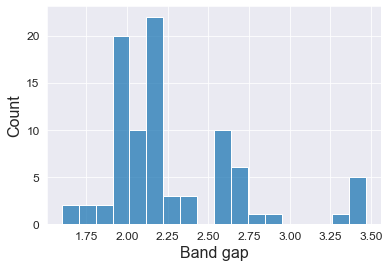

In [17]:
sns.histplot(data=df[(df['BG Type']!='cht')], x='Band gap', bins=18)
plt.show()
#plt.savefig('images/BG_hist.png', dpi=600)

Для всех данных получено:

<div>
<img src="images/BG_hist_full.png" width="800"/>
</div>

Из гистограммы следует, что величина не распределена непрерывна - наблюдается несколько максимумов. Выясним состав:

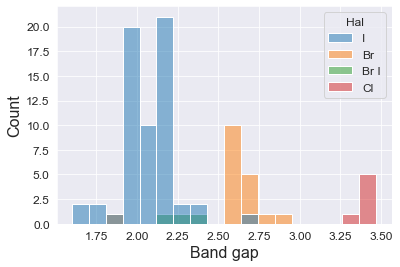

In [18]:
sns.histplot(data=df[(df['BG Type']!='cht')&(df['Band gap'].notna())], x='Band gap', hue='Hal', bins=18)
plt.show()
#plt.savefig('images/BG_halogens_hist.png', dpi=600)

Для всех данных получено:

<div>
<img src="images/BG_halogens_hist_full.png" width="800"/>
</div>

Каждый характерный диапазон соответствует галогенометаллатам с разным типом атомов галогена. Но максимум иода (I) также щепится на два.

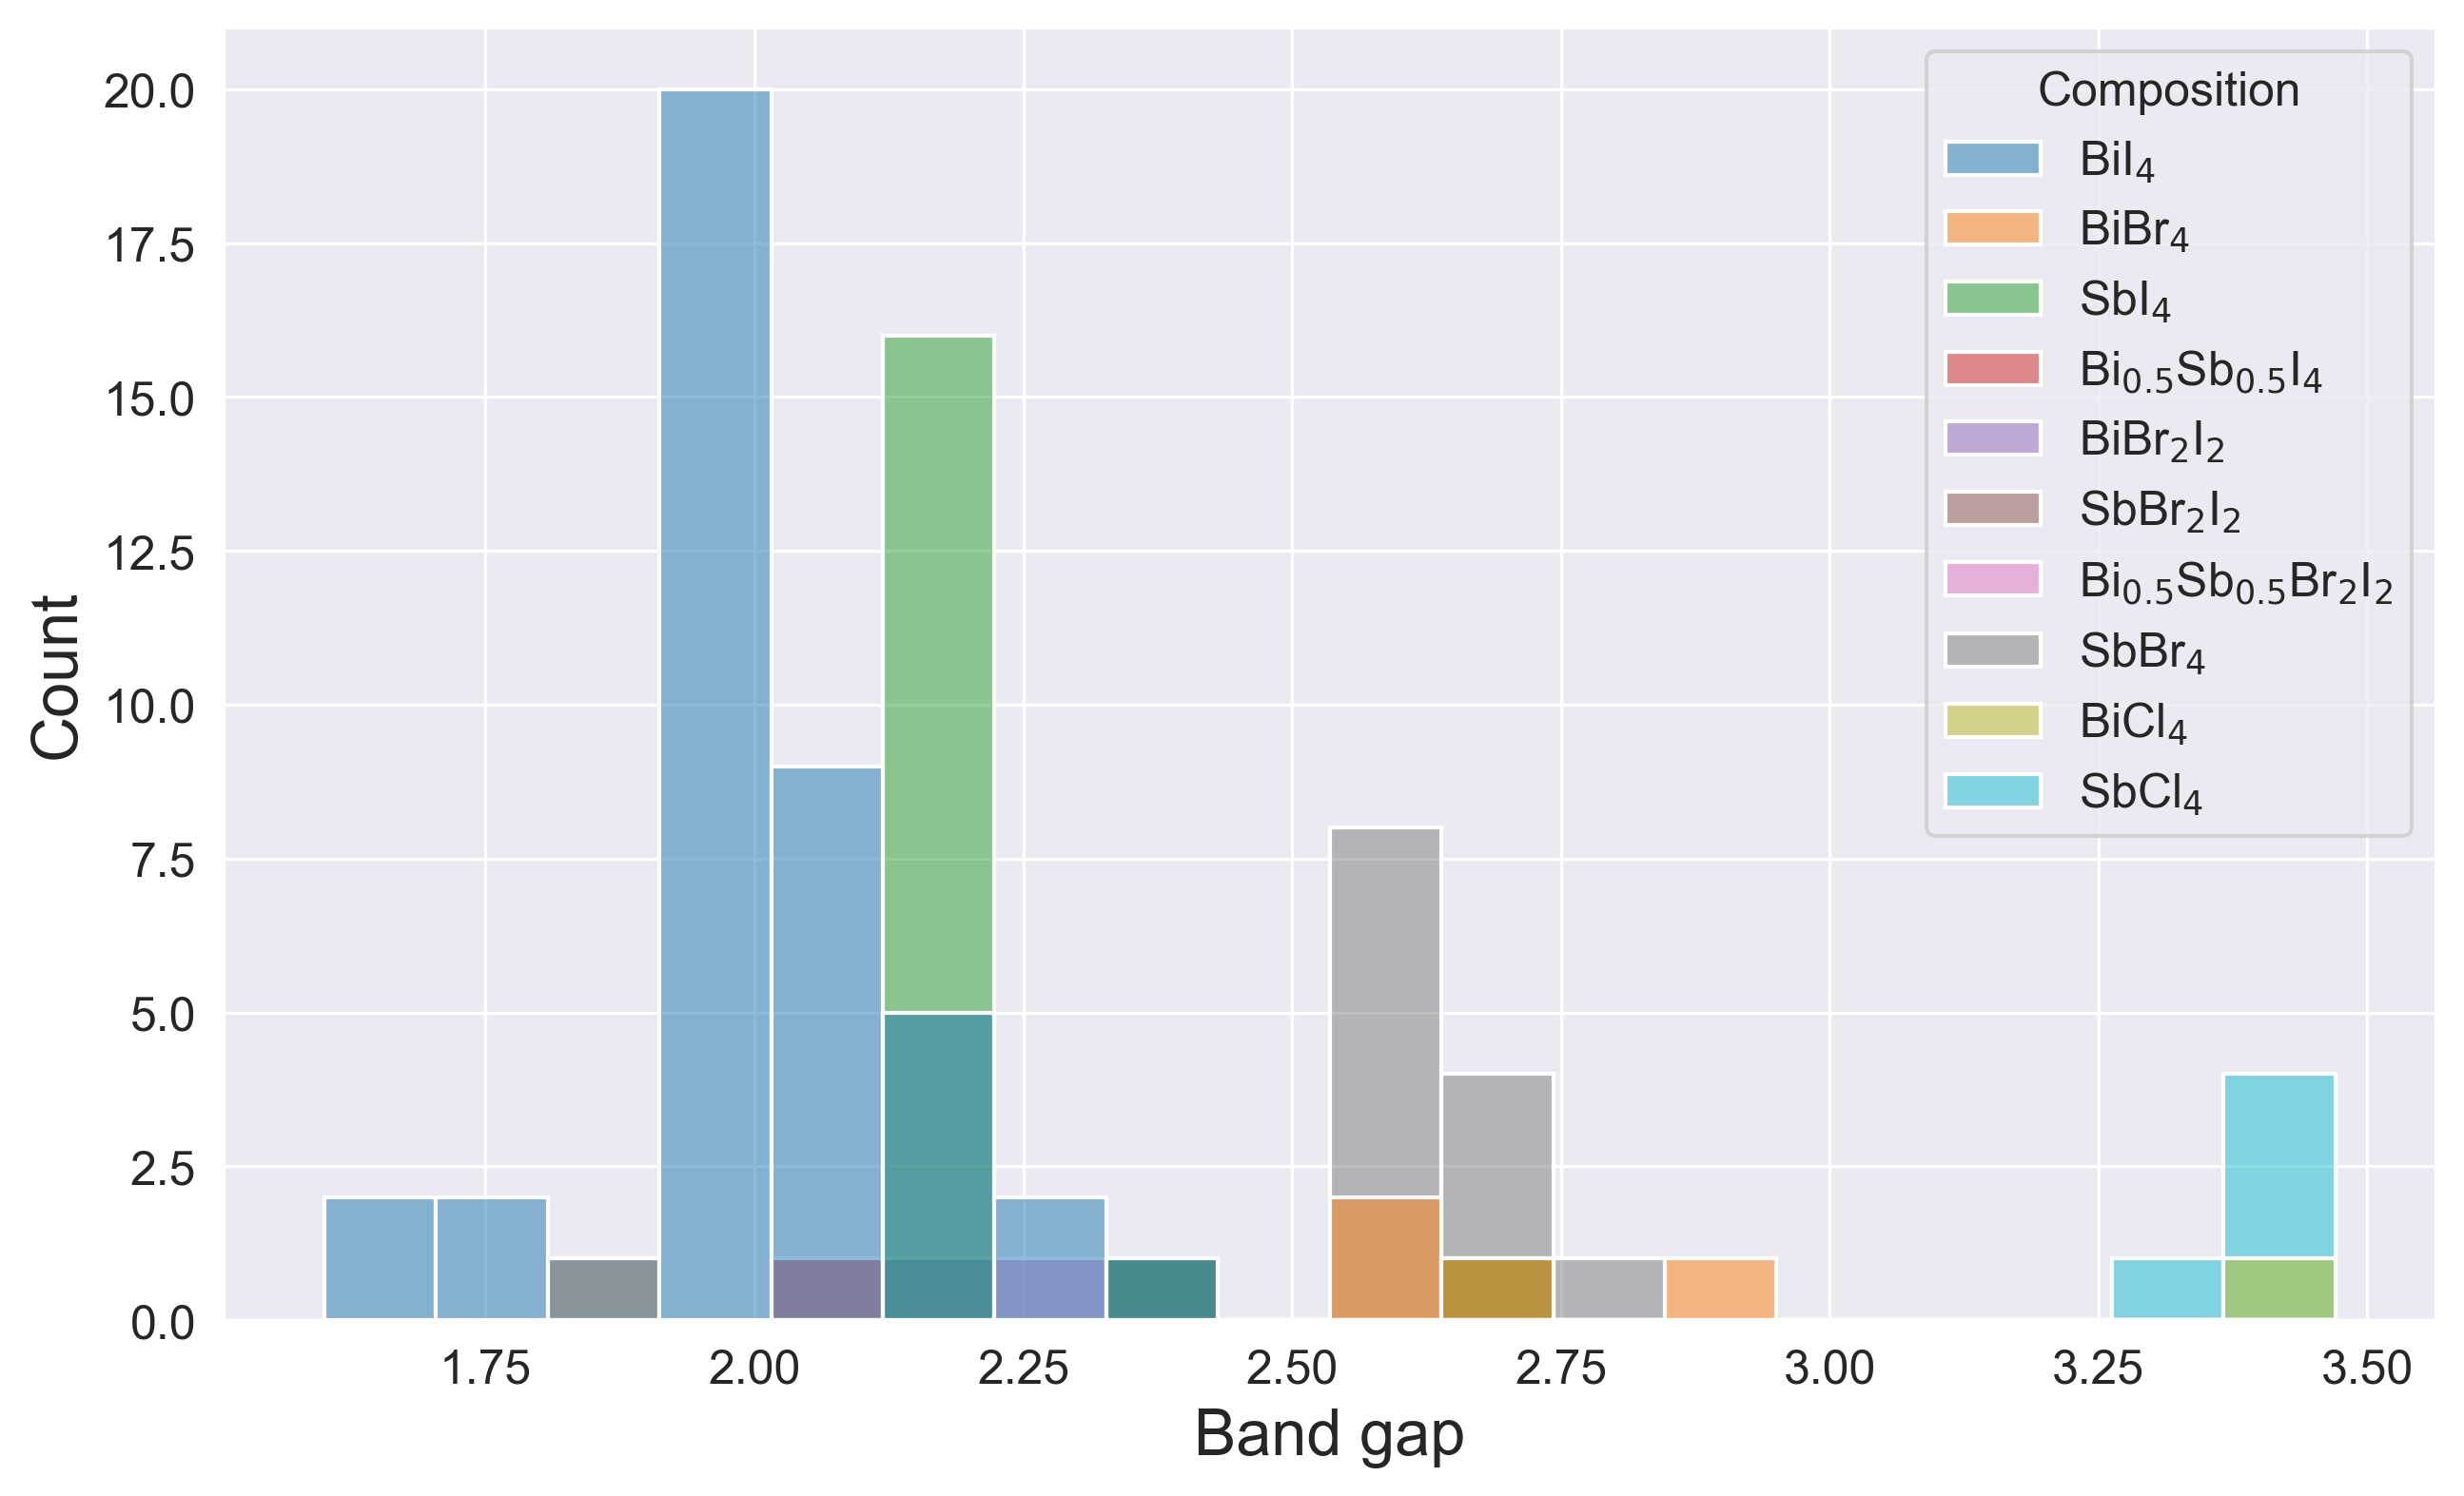

In [19]:
def make_anion_formula(metal, halogen): # Функция для создания правильной записи формул анионов
    metal = metal.replace(' ', '$_{0.5}$') + '$_{0.5}$' if len(metal) > 2 else metal
    halogen = halogen.replace(' ', '$_{2}$') + '$_{2}$' if len(halogen) > 2 else halogen + '$_{4}$'
    return metal + halogen

aid = df[(df['BG Type']!='cht')&(df['Band gap'].notna())].loc[:,['M(III)', 'Hal', 'Band gap']].copy()
aid['Composition'] = [make_anion_formula(met, hal)  for met, hal in zip(aid['M(III)'], aid['Hal'])]
plt.figure(figsize=(10, 6), dpi=300)
sns.histplot(data=aid, x='Band gap', hue='Composition', bins=18)
plt.show()
#plt.savefig('images/BG_composition_hist.png', dpi=600)

Для всех данных получено:

<div>
<img src="images/BG_composition_hist_full.png" width="1200"/>
</div>

Иодидные комплексы имеют разное распределения по ширене запрещенной зоны (ШЗЗ) для висмута и сурьмы

Для учета химического состава нами использованы два вида кодирования - модификации Label-encoder и One-hot-encoder (описание см. в начале).

In [22]:
# Используется библиотека Plotly для построения интерактивных графиков. Некоторые среды (например PyCharm) могут их не отображать.
# В подобном случае - раскомментируйте часть кода ниже:

# import plotly.io as pio
# pio.renderers.default = "browser"

Далее при анализе данных будут рассматриваться типы запрещенных зон. Для некоторых измерений в источниках не указан тип ШЗЗ (модель по которой ее оценивали).
Таких значений:

In [23]:
df[(df['BG Type'].isna())&(df['Band gap'].notna())].shape[0]

6

In [24]:
# Чтобы избежать ошибок заменим Nan в датасете на unk:
for i in df[(df['BG Type'].isna())&(df['Band gap'].notna())].index:
    df.loc[i, 'BG Type'] = 'unk'

Определим сколько соединений и какого состава имеют разные типы ШЗЗ:

In [25]:
list_of_mht_combination = [] # создам для дальнейшего построения графиков
bg_type_dict = {'d': ' direct', 'i': ' indirect', 'cht': ' charge transfer', 'unk': ' unknown type'} # Для красоты в легенде
mh_dict_raw_str ={'Bi': 'Bi', 'Sb': 'Sb', 'Bi Sb': 'Sb<sub>0.5</sub>Bi<sub>0.5</sub>',
                  'I': 'I<sub>4</sub>', 'Br': '<sub>4</sub>', 'Cl': 'Cl<sub>4</sub>', 'Cl Br': 'Cl<sub>2</sub>Br<sub>2</sub>',
                  'Br I': 'Br<sub>2</sub>I<sub>2</sub>' }
for m in df['M(III)'].unique():
    for h in df['Hal'].unique():
        for t in ['d', 'i', 'cht', 'unk']:
            name =  mh_dict_raw_str[m]+mh_dict_raw_str[h]+bg_type_dict[t]
            counts = df[(df['M(III)']==m)&(df['Hal']==h)&(df['BG Type']==t)&(df['Band gap'].notna())].shape[0]
            if counts != 0:
                print(m, h, counts)
                list_of_mht_combination.append((m, h, t, name))

Bi I 33
Bi I 7
Bi I 1
Bi I 2
Bi Cl 1
Bi Cl 1
Bi Br 4
Bi Br 1
Bi Br 1
Bi Br I 1
Sb I 16
Sb I 1
Sb I 2
Sb Cl 2
Sb Cl 2
Sb Cl 1
Sb Cl 1
Sb Br 12
Sb Br 1
Sb Br 1
Sb Br I 1
Bi Sb I 1
Bi Sb Br I 1


In [29]:
from my_scripts import plotly_graphs

In [30]:
# Зависимость ШЗЗ от среднего Hal...Hal расстояния
plotly_graphs(list_of_mht_combination, 'aver Hal...Hal', 'Band gap', df=df, save=False, name_to_save='BG_vs_avHH')

Для всех данных получено:

<div>
<img src="images/BG_vs_avHH_full.png" width="800"/>
</div>

In [31]:
# Зависимость ШЗЗ от минимального Hal...Hal расстояния
plotly_graphs(list_of_mht_combination, 'min Hal...Hal', 'Band gap', df=df, save=False, name_to_save='BG_vs_minHH')

Для всех данных получено:

<div>
<img src="images/BG_vs_minHH_full.png" width="800"/>
</div>

Подозрительно выбивающиеся значения наблюдаются для BAYFOZ, IMUHEG, NAXWUI

In [32]:
# Пока отметим их

# На время, пока доступна ограниченная часть датасета

stange_bg_values = [i for i in df[df['REFCODE'].isin(['BAYFOZ', 'IMUHEG', 'NAXWUI'])].index]

In [33]:
# Зависимость ШЗЗ от показателя степени искажения октаэдров delta d
plotly_graphs(list_of_mht_combination, 'delta d', 'Band gap', df=df, x_range=(0.0, 0.03), dx0=0., dx=0.005, leg_pos=None, save=False, name_to_save='BG_vs_dd')

Для всех данных:

<div>
<img src="images/BG_vs_minHH_full.png" width="800"/>
</div>

In [34]:
# Зависимость ШЗЗ от показателя степени искажения октаэдров sigma^2
plotly_graphs(list_of_mht_combination, 'sigma^2', 'Band gap', df=df, x_range=(0.0, 160), dx0=0., dx=20, leg_pos=None, save=False, name_to_save='BG_vs_sugma2')

Для всех данных получено:

<div>
<img src="images/BG_vs_minHH_full.png" width="800"/>
</div>

В целом, с увеличением показателей степени искжения октаэдров ШЗЗ растет

In [35]:
# Взаимосвязь показателей степени искажения октаэдров delta d и sigma^2
plotly_graphs(list_of_mht_combination, 'delta d', 'sigma^2', df=df, x_range=(0.0, 0.025), dx0=0., dx=0.005, y_range=(0.0, 160), dy0=0, dy=20, leg_pos=dict(x=0.8), save=True, name_to_save='dd_vs_sigma2_full')

Для всех данных получено:

<div>
<img src="images/dd_vs_sigma2_full.png" width="800"/>
</div>

In [36]:
# Зависимость ШЗЗ от дескриптора N/aver-d
plotly_graphs(list_of_mht_combination, 'N/aver-d', 'Band gap', df=df, x_range=(-0.1, 2.15), dx0=-0.25, dx=0.15,leg_pos=None, save=False, name_to_save='BG_vs_Nd')

Для всех данных получено:

<div>
<img src="images/dd_vs_sigma2_full.png" width="800"/>
</div>

Видна дескритизация значений, что связано с тем, что N-связей почти целое число (не очень хорошо)

In [37]:
# Зависимость ШЗЗ от угла t1-Hal - M -Hal-t1
plotly_graphs(list_of_mht_combination, 't1-t2', 'Band gap', df=df, x_range=(85, 115), dx0=0, dx=5,leg_pos=None, save=False, name_to_save='BG_vs_t1HMHt2_angl')

Для всех значений получено:

<div>
<img src="images/BG_vs_t1HMHt2_angl_full.png" width="800"/>
</div>

Посмотрим на корреляцию признаков

In [38]:
corr_map = df[df.columns[7:42]].corr(method='kendall')
corr_np = np.triu(corr_map.to_numpy(), k=1)
#idx = np.unravel_index(corr_np.argmax(), corr_np.shape)
#print("Максимальная корреляция между столбцами {} и {} и равна {:.10f}".format(
 #           list(corr_map)[idx[0]], list(corr_map)[idx[1]], corr_map.iloc[idx]))
corr_np = pd.DataFrame(corr_np, columns=corr_map.columns, index=corr_map.index)
corr_np

,M,X,Bi,Sb,I,Br,Cl,Temperature,min Hal...Hal,aver Hal...Hal,...,t2-d3,t2-d4,d1-d2,d1-d3,d1-d4,d2-d3,d2-d4,d3-d4,delta d,sigma^2
M,0.0,0.27282,-1.00000,1.00000,-0.302279,0.161431,0.193587,-0.056206,-0.219334,-0.240866,...,-0.262318,-0.301585,0.123673,0.312629,0.017614,0.119893,0.132240,0.037116,0.552646,0.141192
X,0.0,0.00000,-0.27282,0.27282,-0.897929,0.213160,0.797997,0.041499,-0.258782,-0.353693,...,-0.314857,-0.315201,-0.136324,0.552656,0.089050,0.265473,0.102500,-0.227694,0.640938,0.302404
Bi,0.0,0.00000,0.00000,-1.00000,0.302279,-0.161431,-0.193587,0.056206,0.219334,0.240866,...,0.262318,0.301585,-0.123673,-0.312629,-0.017614,-0.119893,-0.132240,-0.037116,-0.552646,-0.141192
Sb,0.0,0.00000,0.00000,0.00000,-0.302279,0.161431,0.193587,-0.056206,-0.219334,-0.240866,...,-0.262318,-0.301585,0.123673,0.312629,0.017614,0.119893,0.132240,0.037116,0.552646,0.141192
I,0.0,0.00000,0.00000,0.00000,0.000000,-0.520033,-0.618352,-0.038033,0.312895,0.400072,...,0.294003,0.358512,0.119336,-0.530697,-0.108225,-0.288372,-0.146587,0.214008,-0.655590,-0.245502
Br,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,-0.329150,0.000949,-0.211663,-0.232915,...,-0.023590,-0.242961,0.038838,0.127439,0.069911,0.166850,0.166009,-0.036394,0.272069,-0.121899
Cl,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.046946,-0.153460,-0.228498,...,-0.310391,-0.185714,-0.170520,0.476990,0.060047,0.169120,0.015744,-0.203407,0.477568,0.375108
Temperature,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.143592,0.107956,...,-0.023192,0.001663,-0.065324,0.068001,0.016540,0.007946,0.064036,-0.043890,-0.004827,0.002330
min Hal...Hal,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851182,...,0.110836,0.202076,-0.116400,-0.209652,0.022963,-0.079834,-0.035064,-0.028351,-0.287591,-0.066722
aver Hal...Hal,0.0,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142617,0.215304,-0.081067,-0.238951,-0.012540,-0.082299,-0.053608,-0.015631,-0.338840,-0.105251


Наибольшими коэфицентами корреляции обладают пары дескрипторов:
**Bi** - **M** (1.0) - кодирование одной и той же информации о составе по металлу  One-hot и Label энкодерами
**Sb** - **M** (1.0) - кодирование одной и той же информации о составе по металлу  One-hot и Label энкодерами
**Bi** - **Sb** (-1.0) -  One-hot и Label энкодер
**Number of Hal...Hal contacts** и **N/aver-d** (0.914) - второй пересчитан из первого

Целесообразней будет использовать LE для кодирования состава металла и OHE для галогена, а **Number of Hal...Hal contacts** и **N/aver-d** не использовать вместе

***

## Проанализируем странные значения

In [39]:
# Импорт хеминформатических библеотеки для работы со SMILES
from rdkit import Chem
from rdkit.Chem import Draw

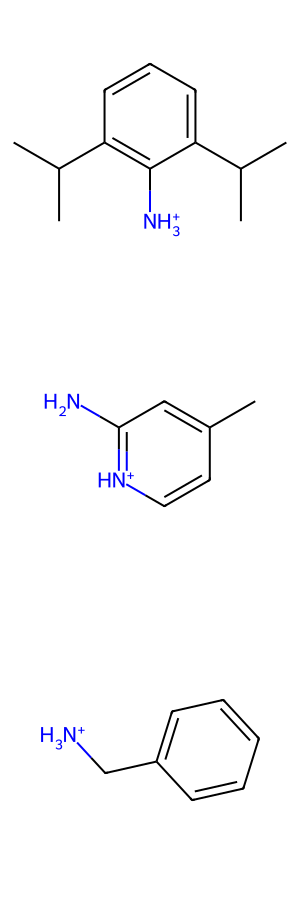

In [40]:
img=Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in df.loc[stange_bg_values, 'cation smiles']], molsPerRow=1,subImgSize=(300,300), returnPNG=False)
img

Все они содержат ароматический катион и для них возможно образование ШЗЗ за счет катиона

BAYFOZ - либо ШЗЗ с переносом заряда, либо артефакт оценки ШЗЗ (спектр довольно странный)

IMUHEG - не очень корректная оценка

NAXWUI - не очень корректная оценка, скорее всего соответсвует экситону

(последние две работы выполнены одними и теми же авторами)

In [41]:
# К сожелению, эти ценные экспериментальные данные не получится использовать в моделях(((
# Удалим их придется удалить

***

## Подготовка данных для обучения

In [42]:
index_to_drop = stange_bg_values # Значения для удаления

In [43]:
# Удаляем лишнюю информацию
df_for_bg_prediction = df.copy()
df_for_bg_prediction.drop(columns=df_for_bg_prediction.columns[42:], index=df_for_bg_prediction[(df_for_bg_prediction['Band gap'].isna())|(df_for_bg_prediction['BG Type']=='cht')].index, inplace=True)
df_for_bg_prediction.drop(index=index_to_drop, columns=['Chemical formula', 'Type MHal4', 'BG Type', 'M(III)', 'Hal'], inplace=True)
df_for_bg_prediction.index = range(len(df_for_bg_prediction.index))

In [44]:
# Сохраняем
df_for_bg_prediction.to_csv('Data_for_bg_prediction.csv', sep='\t')